### 1) Retrieve P3 data from ERP CORE hosted on the OSF repository

The .zip file is 1.83 GB, so this can take a while

In [ ]:
!wget -O P3data.zip https://files.osf.io/v1/resources/etdkz/providers/osfstorage/5f2492d55f705a010e61b15d/?zip=

### 2) Create folder "DATA", unzip "P3data.zip" files into that folder

In [ ]:
!mkdir DATA
!tar -xf "P3data.zip" --directory "DATA"

### 3) Import modules

In [3]:
from glob import glob
import pandas as pd
import mne
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN
from tensorflow.keras.initializers import GlorotUniform, Orthogonal
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

### 4) Check the EEGLAB .set files that have been unzipped

In [4]:
# Get file list of EEGLAB .set files
set_files = glob('./DATA/*/*.set')

# Keep only pre-processed files
set_files = [item for item in set_files if 'ica' in item]

# Sort .set files based on subject ID
sub_ids = [int(item.split('\\')[1]) for item in set_files]
set_files = [item for _,item in sorted(zip(sub_ids,set_files))]

print(len(set_files), '.set files:')
set_files

40 .set files:


['./DATA\\1\\1_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\2\\2_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\3\\3_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\4\\4_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\5\\5_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\6\\6_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\7\\7_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\8\\8_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\9\\9_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\10\\10_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\11\\11_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\12\\12_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\13\\13_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\14\\14_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\15\\15_P3_shifted_ds_reref_ucbip_hpfilt_ic

### 5) Check event codes

In [5]:
evt_codes = pd.read_excel('./DATA/P3_Event_Code_Scheme.xlsx', index_col=0)
evt_codes

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
Active Visual Oddball P3,,,,
NaN,NaN,NaN,NaN,NaN
Stimulus Event Codes,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN
Target (for that block),tens place,Stimulus Type,ones place,Event Code
A,1,A,1,11
B,2,A,1,21
C,3,A,1,31
D,4,A,1,41
E,5,A,1,51


### 6) Check subject summary

In [6]:
sub_summary = pd.read_excel('./DATA/P3_Subject_Summary.xlsx', index_col=0)

# Get the indices for rejecting subjects with entries in "Reason Rejected" column
reject_subs = [i for i in range(40) if not pd.isna(sub_summary.iloc[i]['Reason Rejected'])]
print('Reject subject indexes:', reject_subs)

sub_summary

Reject subject indexes: [5, 8, 9, 29, 34, 39]


,Reason Rejected,Unnamed: 2,Unnamed: 3
SubID,,,
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,"ACC, TC",NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,"AR, TC",NaN,NaN


### 7) Reject subjects

In [7]:
# Reject subjects
set_files = [set_files[i] for i in range(40) if i not in reject_subs]

print('Remaining subjects:', len(set_files))
set_files

Remaining subjects: 34


['./DATA\\1\\1_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\2\\2_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\3\\3_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\4\\4_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\5\\5_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\7\\7_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\8\\8_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\11\\11_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\12\\12_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\13\\13_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\14\\14_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\15\\15_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\16\\16_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\17\\17_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set',
 './DATA\\18\\18_P3_shifted_ds_reref_ucbip_hpfil

### 8) Pre-process EEG and extract segmented trials of ERP data

In [8]:
mne.set_log_level(verbose=False) # Turn off MNE logging output

data = []

for filepath in set_files:

  # Load eeg recordings
  raw = mne.io.read_raw_eeglab(filepath, preload=True)

  # Band-pass filter from 0.1 to 20 Hz
  raw = raw.filter(0.1, 20)

  # Re-sample to 100 Hz
  raw.resample(100)

  # Select channel of interest
  raw = raw.pick(['Pz'])

  # Get event markers
  events, event_id = mne.events_from_annotations(raw)

  # Segment eeg with baseline correction
  epochs = mne.Epochs(raw,
                      events = events,
                      tmin = -0.2,
                      tmax = 1.0,
                      baseline = (-0.2,0),
                      event_id = event_id)

  # Get subject ERP waveforms for each event
  subject_events = []
  for t in range(1,6):
    for s in range(1,6):
      subject_events.append(epochs[f'{t}{s}'].get_data(picks=['Pz']).mean(0))

  # Append subjects ERP waveforms into whole datase
  data.append(subject_events)
  print('DONE:', filepath)

# Transform data into an array and transpose axes
data = np.array(data) * 1e6 # Scale range
data = np.transpose(data, (0,1,3,2))

# Get time vector for plotting waveforms
time = epochs.times

DONE: ./DATA\1\1_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\2\2_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\3\3_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\4\4_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\5\5_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\7\7_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\8\8_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\11\11_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\12\12_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\13\13_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\14\14_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\15\15_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\16\16_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\17\17_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set
DONE: ./DATA\18\18_P3_shifted_ds_reref_ucbip_hpf

### 9) Analyse inter-subject and inter-stimulus correlation with grand-average ERPs

In [9]:
def get_corrcoef(array):
  rs, ps = [], []
  for i in range(len(array)):
    test_erp = array[i]
    train_erp = np.delete(array, i, 0).mean(0)
    r, p = pearsonr(train_erp, test_erp)
    rs.append(r)
    ps.append(p)
  return rs, ps

target_erps = data[:,[0,6,12,18,24]].mean((1,3))
nontarget_erps = data[:,[i for i in range(25) if i not in (0,6,12,18,24)]].mean((1,3))

t_sub_rs, t_sub_ps = get_corrcoef(target_erps)
nt_sub_rs, nt_sub_ps = get_corrcoef(nontarget_erps)

print('By subject:')
print(f'TARGET mean r^2 = {np.mean(t_sub_rs):.3g}, sd = {np.std(t_sub_rs):.3g}')
print(f'NON-TARGET mean r^2 = {np.mean(nt_sub_rs):.3g}, sd = {np.std(nt_sub_rs):.3g}')

target_stim_erps = data[:,[0,6,12,18,24]].mean((0,3))
nontarget_stim_erps = data[:,[i for i in range(25) if i not in (0,6,12,18,24)]].mean((0,3))

t_stim_rs, t_stim_ps = get_corrcoef(target_stim_erps)
nt_stim_rs, nt_stim_ps = get_corrcoef(nontarget_stim_erps)

print('\nBy stimulus:')
print(f'TARGET mean r^2 = {np.mean(t_stim_rs):.3g}, sd = {np.std(t_stim_rs):.3g}')
print(f'NON-TARGET mean r^2 = {np.mean(nt_stim_rs):.3g}, sd = {np.std(nt_stim_rs):.3g}')

By subject:
TARGET mean r^2 = 0.834, sd = 0.105
NON-TARGET mean r^2 = 0.721, sd = 0.196

By stimulus:
TARGET mean r^2 = 0.988, sd = 0.00502
NON-TARGET mean r^2 = 0.976, sd = 0.00859


### 10) Plot grand-average ERPs with errorbars

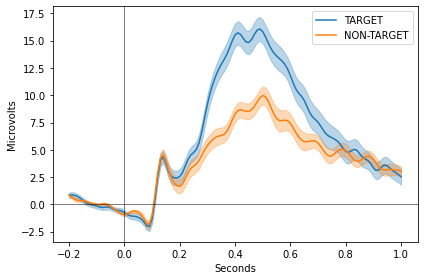

In [10]:
target_erp = target_erps.mean(0)
nontarget_erp = nontarget_erps.mean(0)

target_sem = target_erps.std(0)/np.sqrt(target_erps.shape[0])
nontarget_sem = nontarget_erps.std(0)/np.sqrt(nontarget_erps.shape[0])

plt.figure()
plt.plot(time, target_erp, label='TARGET')
plt.plot(time, nontarget_erp, label='NON-TARGET')
plt.fill_between(time, target_erp-target_sem, target_erp+target_sem, color='C0', alpha=.3)
plt.fill_between(time, nontarget_erp-nontarget_sem, nontarget_erp+nontarget_sem, color='C1', alpha=.3)
plt.legend()
plt.axvline(c='k', lw=.5)
plt.axhline(c='k', lw=.5)
plt.ylabel('Microvolts')
plt.xlabel('Seconds')
plt.tight_layout()
plt.show()

### 11) Plot input conditions

C:\Users\Jamie\AppData\Local\Temp\ipykernel_15920\1068968506.py:15: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(time, (0,1), x_train[0].T, shading='none')
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15920\1068968506.py:21: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(time, (0,1), x_train[1].T, shading='none')


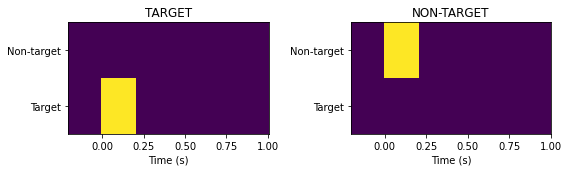

In [11]:
# Construct inputs representing target and non-target trials
x_train = []
for t in range(5):
  for s in range(5):
    x = np.zeros((121,2))
    if t==s:
      x[(time>=0)&(time<=0.2), 0] = 1
    else:
      x[(time>=0)&(time<=0.2), 1] = 1
    x_train.append(x)
x_train = np.array(x_train)

plt.figure(figsize=(8,2.5))
plt.subplot(121)
plt.pcolormesh(time, (0,1), x_train[0].T, shading='nearest')
plt.xlabel('Time (s)')
plt.yticks((0, 1),('Target', 'Non-target'))
plt.title('TARGET')

plt.subplot(122)
plt.pcolormesh(time, (0,1), x_train[1].T, shading='nearest')
plt.xlabel('Time (s)')
plt.yticks((0,1),('Target', 'Non-target'))
plt.title('NON-TARGET')

plt.tight_layout()
plt.show()

### 12) Function for initializing the RNN model

In [12]:
def get_model(seed):
  set_random_seed(seed) # Ensure deterministic performance by setting random seed and initializer random seed
  In = Input(shape=(121,2), name='Input')
  l = SimpleRNN(64, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), recurrent_initializer=Orthogonal(seed=seed), name='Layer1')(In)
  l = SimpleRNN(64, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), recurrent_initializer=Orthogonal(seed=seed), name='Layer2')(l)
  l = SimpleRNN(64, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), recurrent_initializer=Orthogonal(seed=seed), name='Layer3')(l)
  l = SimpleRNN(64, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), recurrent_initializer=Orthogonal(seed=seed), name='Layer4')(l)
  Out = SimpleRNN(1, activation='linear', return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), recurrent_initializer=Orthogonal(seed=seed), name='Output')(l)
  model = Model(In, Out)
  model.compile('adam', 'mse', 'mse')
  return model

# Display model architecture as a flow diagram
plot_model(get_model(0))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### 13) Five-fold cross-validation

In [13]:
# Prepare validation inputs
x_val = np.zeros((2,121,2))
x_val[0,(time>=0)&(time<=0.2),0] = 1 # Target
x_val[1,(time>=0)&(time<=0.2),1] = 1 # Non-target

# Validation event indices
target_val_ids = (0, 6, 12, 18, 24) # AA, BB, CC, DD, EE
nontarget_val_ids = (21, 2, 8, 14, 15) # EB, AC, BD, CE, DA

# Lists for storing model outputs for each fold
val_t_erps, val_nt_erps = [], []

for idx, (t_id, nt_id) in enumerate(zip(target_val_ids, nontarget_val_ids)):

  # Prepare training inputs
  x_train = []
  for t in range(5):
    for s in range(5):
      x = np.zeros((121,2))
      if t==s:
        x[(time>=0)&(time<=0.2), 0] = 1
      else:
        x[(time>=0)&(time<=0.2), 1] = 1
      x_train.append(x)
  x_train = np.array([x_train]*34)

  # Remove validation trials
  x_train = np.delete(x_train, (t_id, nt_id), 1)
  x_train = x_train.reshape(34*23,121,2)
  
  # Prepare validation labels
  y_t_val, y_nt_val = data[:,t_id].mean(0), data[:,nt_id].mean(0)

  # Prepared training labels
  y_train = data[:,[i for i in range(25) if i not in (t_id, nt_id)]]
  y_train = y_train.reshape(34*23,121,1)

  # Initialize model
  model = get_model(1)

  # Traing model
  model.fit(x_train, y_train, batch_size=100, epochs=1000, verbose=0)
  
  # Predict validation outputs
  y_val_pred = model.predict(x_val, verbose=0)

  # Split target and non-target predictions
  y_t_val_pred, y_nt_val_pred = y_val_pred[0], y_val_pred[1]

  # Append predicted validation ERPs to lists
  val_t_erps.append(y_t_val_pred)
  val_nt_erps.append(y_nt_val_pred)

  # Check correlation between model outputs and validation ERPs
  r_t_val, p_t_val = pearsonr(y_t_val[:,0], y_t_val_pred[:,0])
  r_nt_val, p_nt_val = pearsonr(y_nt_val[:,0], y_nt_val_pred[:,0])

  print(f'DONE CV {idx}:')
  print(f'VAL TARGET r^2 = {r_t_val:.3g}, p = {p_t_val:.3g}')
  print(f'VAL NON-TARGET r^2 = {r_nt_val:.3g}, p = {p_nt_val:.3g}')

DONE CV 0:
VAL TARGET r^2 = 0.982, p = 3.31e-88
VAL NON-TARGET r^2 = 0.975, p = 1.09e-79
DONE CV 1:
VAL TARGET r^2 = 0.984, p = 5.38e-91
VAL NON-TARGET r^2 = 0.984, p = 9.68e-92
DONE CV 2:
VAL TARGET r^2 = 0.989, p = 1.24e-101
VAL NON-TARGET r^2 = 0.983, p = 4.19e-89
DONE CV 3:
VAL TARGET r^2 = 0.982, p = 1.3e-88
VAL NON-TARGET r^2 = 0.964, p = 1.52e-70
DONE CV 4:
VAL TARGET r^2 = 0.992, p = 2.28e-110
VAL NON-TARGET r^2 = 0.981, p = 4.52e-86


### 14) Plot cross-validation model outputs and ERPs

DONE CV 0:
VAL TARGET r^2 = 0.982, p = 3.31e-88
VAL NON-TARGET r^2 = 0.975, p = 1.09e-79
DONE CV 1:
VAL TARGET r^2 = 0.984, p = 5.38e-91
VAL NON-TARGET r^2 = 0.984, p = 9.68e-92
DONE CV 2:
VAL TARGET r^2 = 0.989, p = 1.24e-101
VAL NON-TARGET r^2 = 0.983, p = 4.19e-89
DONE CV 3:
VAL TARGET r^2 = 0.982, p = 1.3e-88
VAL NON-TARGET r^2 = 0.964, p = 1.52e-70
DONE CV 4:
VAL TARGET r^2 = 0.992, p = 2.28e-110
VAL NON-TARGET r^2 = 0.981, p = 4.52e-86


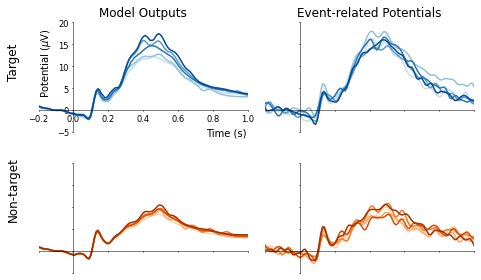

In [14]:
# Convert predicted validation ERPs into arrays
val_t_pred_erps = np.array(val_t_erps)
val_nt_pred_erps =np.array(val_nt_erps)

# Get true validation ERPs 
val_t_true_erps = data[:, target_val_ids].mean(0)
val_nt_true_erps = data[:, nontarget_val_ids].mean(0)

# Iterate through data associated with cross-validation folds
for i in range(5):

  # Measure correlation between model outputs and true ERP waveforms
  r_t_val, p_t_val = pearsonr(val_t_true_erps[i,:,0], val_t_pred_erps[i,:,0])
  r_nt_val, p_nt_val = pearsonr(val_nt_true_erps[i,:,0], val_nt_pred_erps[i,:,0])

  # Report results
  print(f'DONE CV {i}:')
  print(f'VAL TARGET r^2 = {r_t_val:.3g}, p = {p_t_val:.3g}')
  print(f'VAL NON-TARGET r^2 = {r_nt_val:.3g}, p = {p_nt_val:.3g}')

# Plot predicted and true validation ERPs
erps = (val_t_pred_erps,
        val_t_true_erps,
        val_nt_pred_erps,
        val_nt_true_erps)

blues = plt.cm.Blues(np.linspace(0.25,0.9,5))
oranges = plt.cm.Oranges(np.linspace(0.25,0.9,5))
colors = (blues, blues, oranges, oranges)

plt.figure(figsize=(7,4))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.set_title('Model Outputs', fontsize='large')
ax2.set_title('Event-related Potentials', fontsize='large')

ax1.text(-0.15,0.5,'Target', fontsize='large', transform=ax1.transAxes, rotation=90)
ax3.text(-0.15,0.5,'Non-target', fontsize='large', transform=ax3.transAxes, rotation=90)

for i, ax in enumerate((ax1,ax2,ax3,ax4)):
    [ax.plot(time, erp, color=c) for erp,c in zip(erps[i],colors[i])]
    [ax.spines[key].set_linewidth(0.5) for key in ax.spines.keys()]
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key in ['top', 'right']]
    [ax.spines[key].set_position(('data', 0)) for key in ax.spines.keys() if key in ['bottom', 'left']]
    ax.set_ylim((-5, 20))
    ax.set_xlim((-0.2, 1.0))
    ax.tick_params(length=1, labelsize='small')
    if i > 0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xlabel('Time (s)', fontsize='medium', x=0.9)
        ax.set_ylabel('Potential ($\mu$V)', fontsize='medium', y=0.95, ha='right')

plt.tight_layout(rect=(0.02,0,0.98,1))
plt.show()

### 15) Train final RNN using all ERP data

In [15]:
# Prepare training inputs
x_train = []
for t in range(5):
  for s in range(5):
    x = np.zeros((121,2))
    if t==s:
      x[(time>=0)&(time<=0.2), 0] = 1
    else:
      x[(time>=0)&(time<=0.2), 1] = 1
    x_train.append(x)
x_train = np.array([x_train]*34)
x_train = x_train.reshape(34*25,121,2)

# Prepare training labels
y_train = data.reshape(34*25,121,1)

# Create model checkpoint
save_model = ModelCheckpoint('model_final.h5', monitor='loss', save_best_ony=True)

# Initialize model
model = get_model(1)

# Train model
history = model.fit(x_train, y_train, batch_size=100, epochs=1000, verbose=1, callbacks=[save_model])

Epoch 1/1000
9/9 [==============================] - 3s 95ms/step - loss: 65.8213 - mse: 65.8213
Epoch 2/1000
9/9 [==============================] - 1s 101ms/step - loss: 44.0170 - mse: 44.0170
Epoch 3/1000
9/9 [==============================] - 1s 95ms/step - loss: 40.7485 - mse: 40.7485
Epoch 4/1000
9/9 [==============================] - 1s 95ms/step - loss: 39.5517 - mse: 39.5517
Epoch 5/1000
9/9 [==============================] - 1s 97ms/step - loss: 39.2530 - mse: 39.2530
Epoch 6/1000
9/9 [==============================] - 1s 96ms/step - loss: 39.7843 - mse: 39.7843
Epoch 7/1000
9/9 [==============================] - 1s 94ms/step - loss: 39.4305 - mse: 39.4305
Epoch 8/1000
9/9 [==============================] - 1s 95ms/step - loss: 39.7227 - mse: 39.7227
Epoch 9/1000
9/9 [==============================] - 1s 94ms/step - loss: 39.7293 - mse: 39.7293
Epoch 10/1000
9/9 [==============================] - 1s 97ms/step - loss: 38.5160 - mse: 38.5160
Epoch 11/1000
9/9 [===================

9/9 [==============================] - 1s 95ms/step - loss: 38.1227 - mse: 38.1227
Epoch 169/1000
9/9 [==============================] - 1s 96ms/step - loss: 38.0913 - mse: 38.0913
Epoch 170/1000
9/9 [==============================] - 1s 92ms/step - loss: 38.0406 - mse: 38.0406
Epoch 171/1000
9/9 [==============================] - 1s 94ms/step - loss: 38.0428 - mse: 38.0428
Epoch 172/1000
9/9 [==============================] - 1s 94ms/step - loss: 38.3101 - mse: 38.3101
Epoch 173/1000
9/9 [==============================] - 1s 95ms/step - loss: 38.2897 - mse: 38.2897
Epoch 174/1000
9/9 [==============================] - 1s 97ms/step - loss: 38.0922 - mse: 38.0922
Epoch 175/1000
9/9 [==============================] - 1s 92ms/step - loss: 38.8843 - mse: 38.8843
Epoch 176/1000
9/9 [==============================] - 1s 94ms/step - loss: 38.1415 - mse: 38.1415
Epoch 177/1000
9/9 [==============================] - 1s 100ms/step - loss: 38.0839 - mse: 38.0840
Epoch 178/1000
9/9 [==============

9/9 [==============================] - 1s 90ms/step - loss: 38.3135 - mse: 38.3135
Epoch 335/1000
9/9 [==============================] - 1s 93ms/step - loss: 38.3003 - mse: 38.3003
Epoch 336/1000
9/9 [==============================] - 1s 93ms/step - loss: 37.9971 - mse: 37.9970
Epoch 337/1000
9/9 [==============================] - 1s 92ms/step - loss: 37.9077 - mse: 37.9077
Epoch 338/1000
9/9 [==============================] - 1s 91ms/step - loss: 38.0331 - mse: 38.0331
Epoch 339/1000
9/9 [==============================] - 1s 90ms/step - loss: 38.0087 - mse: 38.0087
Epoch 340/1000
9/9 [==============================] - 1s 89ms/step - loss: 37.9186 - mse: 37.9186
Epoch 341/1000
9/9 [==============================] - 1s 96ms/step - loss: 38.0946 - mse: 38.0946
Epoch 342/1000
9/9 [==============================] - 1s 96ms/step - loss: 38.0223 - mse: 38.0223
Epoch 343/1000
9/9 [==============================] - 1s 94ms/step - loss: 38.1594 - mse: 38.1594
Epoch 344/1000
9/9 [===============

9/9 [==============================] - 1s 94ms/step - loss: 38.1373 - mse: 38.1373
Epoch 501/1000
9/9 [==============================] - 1s 94ms/step - loss: 38.3105 - mse: 38.3105
Epoch 502/1000
9/9 [==============================] - 1s 89ms/step - loss: 38.3257 - mse: 38.3257
Epoch 503/1000
9/9 [==============================] - 1s 93ms/step - loss: 38.0308 - mse: 38.0308
Epoch 504/1000
9/9 [==============================] - 1s 95ms/step - loss: 37.9527 - mse: 37.9527
Epoch 505/1000
9/9 [==============================] - 1s 92ms/step - loss: 37.9864 - mse: 37.9864
Epoch 506/1000
9/9 [==============================] - 1s 87ms/step - loss: 38.0331 - mse: 38.0331
Epoch 507/1000
9/9 [==============================] - 1s 91ms/step - loss: 38.2222 - mse: 38.2222
Epoch 508/1000
9/9 [==============================] - 1s 90ms/step - loss: 37.8768 - mse: 37.8768
Epoch 509/1000
9/9 [==============================] - 1s 90ms/step - loss: 38.0117 - mse: 38.0117
Epoch 510/1000
9/9 [===============

9/9 [==============================] - 1s 89ms/step - loss: 38.1616 - mse: 38.1616
Epoch 667/1000
9/9 [==============================] - 1s 87ms/step - loss: 38.2315 - mse: 38.2315
Epoch 668/1000
9/9 [==============================] - 1s 90ms/step - loss: 38.4946 - mse: 38.4946
Epoch 669/1000
9/9 [==============================] - 1s 88ms/step - loss: 38.1199 - mse: 38.1199
Epoch 670/1000
9/9 [==============================] - 1s 88ms/step - loss: 38.0557 - mse: 38.0557
Epoch 671/1000
9/9 [==============================] - 1s 86ms/step - loss: 38.0094 - mse: 38.0094
Epoch 672/1000
9/9 [==============================] - 1s 90ms/step - loss: 37.8358 - mse: 37.8358
Epoch 673/1000
9/9 [==============================] - 1s 88ms/step - loss: 38.3061 - mse: 38.3061
Epoch 674/1000
9/9 [==============================] - 1s 89ms/step - loss: 38.0549 - mse: 38.0549
Epoch 675/1000
9/9 [==============================] - 1s 87ms/step - loss: 38.0193 - mse: 38.0193
Epoch 676/1000
9/9 [===============

9/9 [==============================] - 1s 87ms/step - loss: 37.9052 - mse: 37.9052
Epoch 833/1000
9/9 [==============================] - 1s 88ms/step - loss: 37.9237 - mse: 37.9237
Epoch 834/1000
9/9 [==============================] - 1s 87ms/step - loss: 37.9684 - mse: 37.9684
Epoch 835/1000
9/9 [==============================] - 1s 92ms/step - loss: 38.3590 - mse: 38.3590
Epoch 836/1000
9/9 [==============================] - 1s 92ms/step - loss: 38.0342 - mse: 38.0342
Epoch 837/1000
9/9 [==============================] - 1s 90ms/step - loss: 38.0330 - mse: 38.0330
Epoch 838/1000
9/9 [==============================] - 1s 88ms/step - loss: 38.2045 - mse: 38.2045
Epoch 839/1000
9/9 [==============================] - 1s 84ms/step - loss: 38.0301 - mse: 38.0301
Epoch 840/1000
9/9 [==============================] - 1s 86ms/step - loss: 37.9836 - mse: 37.9836
Epoch 841/1000
9/9 [==============================] - 1s 87ms/step - loss: 38.9438 - mse: 38.9438
Epoch 842/1000
9/9 [===============

9/9 [==============================] - 1s 92ms/step - loss: 38.0251 - mse: 38.0251
Epoch 999/1000
9/9 [==============================] - 1s 88ms/step - loss: 37.9196 - mse: 37.9196
Epoch 1000/1000
9/9 [==============================] - 1s 92ms/step - loss: 37.8888 - mse: 37.8888


### 16) Plot model learning curve

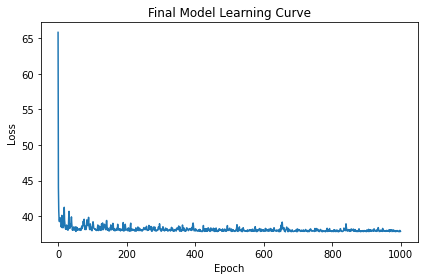

In [16]:
plt.figure()
plt.plot(history.epoch, history.history['mse'])
plt.title('Final Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

### 17) Plot final model outputs compared with grand-average ERPs

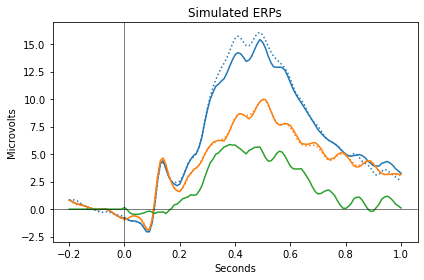

In [17]:
# Prepare validation inputs
x_val = np.zeros((2,121,2))
x_val[0,(time>=0)&(time<=0.2),0] = 1 # Target
x_val[1,(time>=0)&(time<=0.2),1] = 1 # Non-target

y_pred = model.predict(x_val, verbose=0)

target_pred = y_pred[0]
nontarget_pred = y_pred[1]

plt.figure()
plt.plot(time, target_pred, c='C0')
plt.plot(time, target_erp, c='C0', ls=':')
plt.plot(time, nontarget_pred, c='C1')
plt.plot(time, nontarget_erp, c='C1', ls=':')
plt.plot(time, target_pred-nontarget_pred, c='C2')
plt.title('Simulated ERPs')
plt.axvline(c='k', lw=.5)
plt.axhline(c='k', lw=.5)
plt.ylabel('Microvolts')
plt.xlabel('Seconds')

plt.tight_layout()
plt.show()

### 18) Get multi-output model to analyse hidden unit activations

In [18]:
# Create model with  outputs from every layer
act_model = Model(model.input, [layer.output for layer in model.layers])

# Get hidden unit activations by predicting responses to validation inputs
acts = act_model.predict(x_val, verbose=0)

# Check the shapes of model outputs
for i, a in enumerate(acts):
  print(f'Layer {i+1} output shape: {a.shape}')

# Select outputs from recurrent layers only
rnn_acts = acts[-5:]

Layer 1 output shape: (2, 121, 2)
Layer 2 output shape: (2, 121, 64)
Layer 3 output shape: (2, 121, 64)
Layer 4 output shape: (2, 121, 64)
Layer 5 output shape: (2, 121, 64)
Layer 6 output shape: (2, 121, 1)


### 19) Plot hidden unit activations as matrix images

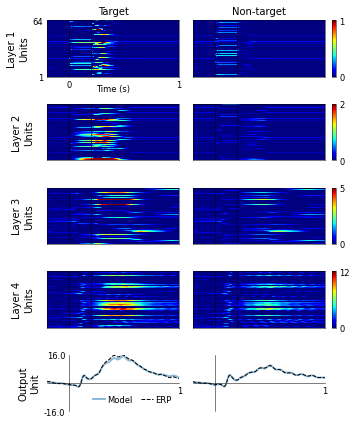

In [19]:
# Get target and non-target ERPs
t_erp = data[:,[0,6,12,18,24]].mean((0,1,3))
nt_erp = data[:,[i for i in range(25) if i not in (0,6,12,18,24)]].mean((0,1,3))
erps = [t_erp, nt_erp]

# Find suitable limits for color mapping
vmax_l1 = max((np.floor(max(np.abs([rnn_acts[0].max(), rnn_acts[0].min()]))*0.75), 1))
vmax_l2 = np.floor(max(np.abs([rnn_acts[1].max(), rnn_acts[1].min()]))*0.75)
vmax_l3 = np.floor(max(np.abs([rnn_acts[2].max(), rnn_acts[2].min()]))*0.75)
vmax_l4 = np.floor(max(np.abs([rnn_acts[3].max(), rnn_acts[3].min()]))*0.75)
vmax_l5 = np.ceil(max(np.abs([rnn_acts[4].max(), rnn_acts[4].min()])))

# Plot model hidden unit responses in a multi-panel figure
titles = ['Target' , 'Non-target']
plt.figure(figsize=(5,6))

for i in range(2):

  ax_l1 = plt.subplot(5,2,i+1)
  ax_l2 = plt.subplot(5,2,i+3)
  ax_l3 = plt.subplot(5,2,i+5)
  ax_l4 = plt.subplot(5,2,i+7)
  ax_out = plt.subplot(5,2,i+9)

  if i == 0:
    ax_l1.set_ylabel('Layer 1\nUnits', fontsize='medium')
    ax_l2.set_ylabel('Layer 2\nUnits', fontsize='medium', labelpad=13)
    ax_l3.set_ylabel('Layer 3\nUnits', fontsize='medium', labelpad=13)
    ax_l4.set_ylabel('Layer 4\nUnits', fontsize='medium', labelpad=13)
    yl = ax_out.set_ylabel('Output\nUnit', fontsize='medium')

  if i < 4:
    ax_l1.set_title(titles[i], fontsize='medium')

  for ax in [ax_l1, ax_l2, ax_l3, ax_l4, ax_out]:
    ax.tick_params(labelsize='small', length=0)
    ax.set_xticks([])
    ax.set_yticks([])
    [ax.spines[key].set_linewidth(0.5) for key in ax.spines.keys()]

  if i == 0:
    ax_l1.set_xticks([0, 1])
    ax_l1.set_yticks([0, 63])
    ax_l1.set_yticklabels(('1', '64'))
    ax_l1.set_xlabel('Time (s)', labelpad=-5, fontsize='small')

  c1 = ax_l1.pcolormesh(time, range(64), rnn_acts[0][i].T, shading='nearest', vmin=0, vmax=vmax_l1, cmap='jet')
  c2 = ax_l2.pcolormesh(time, range(64), rnn_acts[1][i].T, shading='nearest', vmin=0, vmax=vmax_l2, cmap='jet')
  c3 = ax_l3.pcolormesh(time, range(64), rnn_acts[2][i].T, shading='nearest', vmin=0, vmax=vmax_l3, cmap='jet')
  c4 = ax_l4.pcolormesh(time, range(64), rnn_acts[3][i].T, shading='nearest', vmin=0, vmax=vmax_l4, cmap='jet')

  for ax in [ax_l1, ax_l2, ax_l3, ax_l4]:
    ax.axvline(x=0, lw=.75, color='k', ls='--')
    ax.axvline(x=0.2, lw=.75, color='k', ls='--')

  ax_out.set_ylim((-vmax_l5, vmax_l5))
  [ax_out.spines[key].set_visible(False) for key in ax_out.spines.keys() if key in ['right', 'top']]
  [ax_out.spines[key].set_position(('data', 0.0)) for key in ax_out.spines.keys() if key in ['left', 'bottom']]
  ax_out.set_xticks([1])
  ax_out.plot(time, rnn_acts[4][i], lw=2, c='C0', alpha=.5, label='Model')
  if i < 2:
    ax_out.plot(time, erps[i], lw=1, ls='--', c='k', label='ERP')
  ax_out.set_yticks([])
  ax_out.set_xlim((-0.2, 1))
  ax_out.set_ylim((-vmax_l5, vmax_l5))

  if i == 0:
    ax_out.legend(loc='lower right', fontsize='small', frameon=False, ncol=2,
                  columnspacing=1, handlelength=1.5, handletextpad=0.25)
    ax_out.set_yticks([-vmax_l5, vmax_l5])
    ax_out.set_yticklabels([str(-vmax_l5), str(vmax_l5)])

plt.tight_layout(rect=(0,0,0.95,1))

# Set color axes only on right hand side panels
for c, ax, vmax in zip([c1, c2, c3, c4], [ax_l1, ax_l2, ax_l3, ax_l4], [vmax_l1, vmax_l2, vmax_l3, vmax_l4]):
  x, y, w, h = ax.get_position().bounds
  cb_ax = plt.axes((x+w+0.02, y, 0.01, h))
  cb = plt.colorbar(c, cax=cb_ax)
  cb.ax.tick_params(labelsize='small', length=0)
  cb.set_ticks((0, vmax))
  [cb.ax.spines[key].set_linewidth(0.5) for key in cb.ax.spines.keys()]

plt.show()

### 20) Find hidden unit activation peak latencies in response to each input condition and their difference

In [20]:
# Get the difference between hidden unit responses to target and non-target inputs
for i in range(len(rnn_acts)):
  rnn_acts[i] = np.concatenate([rnn_acts[i],np.expand_dims(rnn_acts[i][0]-rnn_acts[i][1], 0)])

# Add difference waveform to ERPs
erps = [t_erp, nt_erp, t_erp-nt_erp]

# Find peak latency of each hidden unit for each condition
results = np.zeros((4,3,64))
for i in range(3): # Stimulus conditions
  for j in range(64): # Units
    for k in range(4): # Layers
      unit = rnn_acts[k][i,:,j]
      peak_idx = np.argmax(unit)
      peak_time = time[peak_idx]
      results[k,i,j] = peak_time

# Classify hidden units by peak latency
condition_groups = []
for results_condition in [results[:,0], results[:,1], results[:,2]]:
  groups = np.zeros((4,64), 'int')
  groups[results_condition==-0.2] = 0 # zero units (no activity)
  groups[(results_condition>-0.2)&(results_condition<=0)] = 1 # <0.0 s units
  groups[(results_condition>0)&(results_condition<=0.1)] = 2 # 0.0-0.1 s units
  groups[(results_condition>0.1)&(results_condition<=0.2)] = 3 # 0.1-0.2 s units
  groups[(results_condition>0.2)&(results_condition<=0.3)] = 4 # 0.2-0.3 s units
  groups[(results_condition>0.3)&(results_condition<=0.4)] = 5 # 0.3-0.4 s units
  groups[(results_condition>0.4)&(results_condition<=0.6)] = 6 # 0.4-0.6 s units
  groups[(results_condition>0.6)] = 7 # >0.6 s units
  condition_groups.append(groups)
condition_groups = np.array(condition_groups)

# Output findings
for condition, groups in zip(['Target', 'Non-target', 'Difference'], condition_groups):
  print('\n'+condition.upper())
  for i in range(4):
    print('-'*25)
    print(f'L{i+1} # zero units: {(groups[i]==0).sum()}')
    print(f'L{i+1} # <0.0 s units: {(groups[i]==1).sum()}')
    print(f'L{i+1} # 0.0-0.1 s units: {(groups[i]==2).sum()}')
    print(f'L{i+1} # 0.1-0.2 s units: {(groups[i]==3).sum()}')
    print(f'L{i+1} # 0.2-0.3 s units: {(groups[i]==4).sum()}')
    print(f'L{i+1} # 0.3-0.4 s units: {(groups[i]==5).sum()}')
    print(f'L{i+1} # 0.4-0.6 s units: {(groups[i]==6).sum()}')
    print(f'L{i+1} # >0.6 s units: {(groups[i]==7).sum()}')


TARGET
-------------------------
L1 # zero units: 14
L1 # <0.0 s units: 2
L1 # 0.0-0.1 s units: 7
L1 # 0.1-0.2 s units: 0
L1 # 0.2-0.3 s units: 28
L1 # 0.3-0.4 s units: 10
L1 # 0.4-0.6 s units: 3
L1 # >0.6 s units: 0
-------------------------
L2 # zero units: 20
L2 # <0.0 s units: 4
L2 # 0.0-0.1 s units: 6
L2 # 0.1-0.2 s units: 2
L2 # 0.2-0.3 s units: 9
L2 # 0.3-0.4 s units: 13
L2 # 0.4-0.6 s units: 9
L2 # >0.6 s units: 1
-------------------------
L3 # zero units: 11
L3 # <0.0 s units: 4
L3 # 0.0-0.1 s units: 13
L3 # 0.1-0.2 s units: 0
L3 # 0.2-0.3 s units: 9
L3 # 0.3-0.4 s units: 5
L3 # 0.4-0.6 s units: 10
L3 # >0.6 s units: 12
-------------------------
L4 # zero units: 17
L4 # <0.0 s units: 4
L4 # 0.0-0.1 s units: 10
L4 # 0.1-0.2 s units: 5
L4 # 0.2-0.3 s units: 1
L4 # 0.3-0.4 s units: 2
L4 # 0.4-0.6 s units: 23
L4 # >0.6 s units: 2

NON-TARGET
-------------------------
L1 # zero units: 13
L1 # <0.0 s units: 9
L1 # 0.0-0.1 s units: 21
L1 # 0.1-0.2 s units: 0
L1 # 0.2-0.3 s units: 13

### 21) Plot hidden unit activations in the time-domain

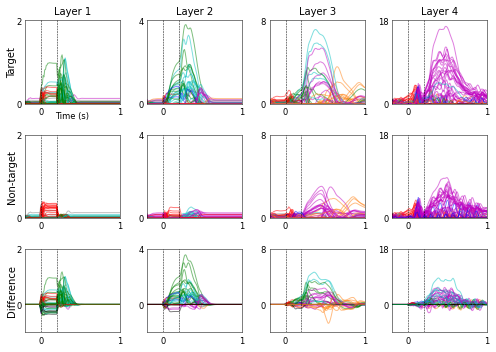

In [21]:
# Get each recurrent layer ouptuts
l1, l2, l3, l4, l5 = rnn_acts

# Find suitable y-axis limit for time-domain plotting
vmax_l1 = np.ceil(np.max(l1)*1.05)
vmax_l2 = np.ceil(np.max(l2)*1.05)
vmax_l3 = np.ceil(np.max(l3)*1.05)
vmax_l4 = np.ceil(np.max(l4)*1.05)
vmax = [vmax_l1, vmax_l2, vmax_l3, vmax_l4]

# Plot hidden unit activations in multi-panel figure
colors = ('k', 'gray', 'r', 'b', 'g', 'c', 'm', 'C1')
plt.figure(figsize=(7,5))
for x, title in enumerate(['Target', 'Non-target', 'Difference']):

  for i, layer in enumerate([l1,l2,l3,l4]):
      
    ax = plt.subplot(3,4,(x*4)+(i+1))

    [ax.spines[key].set_linewidth(0.5) for key in ax.spines.keys()]

    for j in range(0, 64):
      plt.plot(time, layer[x,:,j], c=colors[condition_groups[x][i,j]], lw=1, alpha=0.5)

    plt.axvline(0, color='k', lw=.5, ls='--')
    plt.axvline(0.2, color='k', lw=.5, ls='--')
    plt.ylim((-0.05*vmax[i], vmax[i]))
    plt.tick_params(labelsize='small', length=0)
    plt.xticks([0, 1])
    plt.yticks([0, vmax[i]])
    plt.xlim((-0.2, 1))
    plt.ylim((0, vmax[i]))
    if x == 2:
      plt.ylim(bottom=-0.5*vmax[i])
    
    if x == 0:
      plt.title(f'Layer {i+1}', fontsize='medium')
      if i == 0:
        plt.xlabel('Time (s)', fontsize='small', labelpad=-5)
    if i == 0:
      plt.ylabel(title, rotation=90, fontsize='medium', va='center')       

plt.tight_layout()
plt.show()

### 22) Perform principal component analysis

Original dimensions: (64, 121)
Explained variance: [0.6051587  0.777253   0.88270324]
Original dimensions: (64, 121)
Explained variance: [0.87071186 0.93555135 0.9567529 ]
Original dimensions: (64, 121)
Explained variance: [0.8365359  0.9069129  0.94342244]
Original dimensions: (64, 121)
Explained variance: [0.9298537  0.95865035 0.9731743 ]
Original dimensions: (64, 121)
Explained variance: [0.7487737  0.9036409  0.94402826]
Original dimensions: (64, 121)
Explained variance: [0.42675933 0.68412817 0.89366394]
Original dimensions: (64, 121)
Explained variance: [0.54134214 0.7563385  0.9313428 ]
Original dimensions: (64, 121)
Explained variance: [0.8702618  0.90626734 0.93862677]
Original dimensions: (64, 121)
Explained variance: [0.6113311  0.81070644 0.9045706 ]
Original dimensions: (64, 121)
Explained variance: [0.8758187 0.9337435 0.9595384]
Original dimensions: (64, 121)
Explained variance: [0.8131675  0.89025056 0.94162387]
Original dimensions: (64, 121)
Explained variance: [0.855

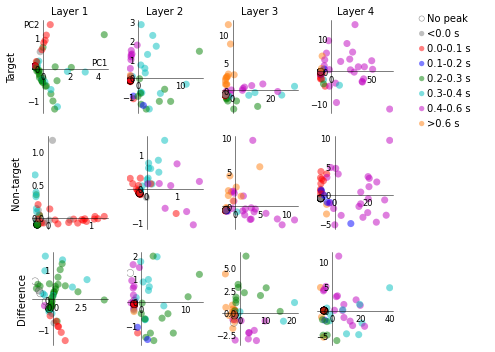

In [22]:
# PCA by unit for each layer
xs_t = [act.T[:,:,0] for act in rnn_acts[:-1]]
xs_nt = [act.T[:,:,1] for act in rnn_acts[:-1]]
xs_dif = [act.T[:,:,2] for act in rnn_acts[:-1]]

ax_ids = [1,2,3,4]

color_codes = ('none', 'gray', 'r', 'b', 'g', 'c', 'm', 'C1')
edge_codes = ('k', 'none', 'none', 'none', 'none', 'none', 'none', 'none')

titles = ['Layer 1' ,'Layer 2' , 'Layer 3', 'Layer 4']
labels = ['No peak', '<0.0 s', '0.0-0.1 s', '0.1-0.2 s', '0.2-0.3 s',
          '0.3-0.4 s', '0.4-0.6 s', '>0.6 s']
l1, l2, l3, l4, l5, l6, l7, l8 = [None]*8
axes, lines = [], []

plt.figure(figsize=(7,5))
groups = condition_groups[0]
for i, x, in enumerate(xs_t):

    print('Original dimensions:', x.shape)

    pca = PCA()
    x_c = pca.fit_transform(x)

    print('Explained variance:', np.cumsum(pca.explained_variance_ratio_)[:3])
    
    ax = plt.subplot(3,5,i+1)
    [ax.spines[key].set_linewidth(.5) for key in ax.spines.keys()]
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key in ['right', 'top']]
    [ax.spines[key].set_position(('data',0.0)) for key in ax.spines.keys() if key in ['left', 'bottom']]
    ax.tick_params(labelsize='small', length=0)
    ax.xaxis.set_label_position('bottom')
    ax.set_title(titles[i], fontsize='medium')

    if i == 0:
        ax.set_ylabel('Target', fontsize='medium', labelpad=10)
        ax.text(1, 0.5, 'PC1', fontsize='small', ha='right',va='bottom', transform=ax.transAxes)
        ax.text(0.1, 1, 'PC2', fontsize='small', ha='right',va='top', transform=ax.transAxes)
    
    for j in range(64):
        l = plt.scatter(x_c[j,0], x_c[j,1], s=50, c=color_codes[groups[i,j]], alpha=.5,
                        edgecolors=edge_codes[groups[i,j]], lw=.5)
        if groups[i,j] == 0 and l1 == None:
            l1 = l
            lines.append([l1, 0])
        elif groups[i,j] == 1 and l2 == None:
            l2 = l
            lines.append([l2, 1])
        elif groups[i,j] == 2 and l3 == None:
            l3 = l
            lines.append([l3, 2])
        elif groups[i,j] == 3 and l4 == None:
            l4 = l
            lines.append([l4, 3])
        elif groups[i,j] == 4 and l5 == None:
            l5 = l
            lines.append([l5, 4])
        elif groups[i,j] == 5 and l6 == None:
            l6 = l
            lines.append([l6, 5])
        elif groups[i,j] == 6 and l7 == None:
            l7 = l
            lines.append([l7, 6])
        elif groups[i,j] == 7 and l8 == None:
            l8 = l
            lines.append([l8, 7])
            
    axes.append(ax)

lines.sort(key = lambda x: x[1])
lines, _ = zip(*lines)

# REPEAT FOR NON-TARGET CONDITION
groups = condition_groups[1]
for i, x, in enumerate(xs_nt):

    print('Original dimensions:', x.shape)

    pca = PCA()
    x_c = pca.fit_transform(x)

    print('Explained variance:', np.cumsum(pca.explained_variance_ratio_)[:3])
    
    ax = plt.subplot(3,5,i+6)
    [ax.spines[key].set_linewidth(.5) for key in ax.spines.keys()]
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key in ['right', 'top']]
    [ax.spines[key].set_position(('data',0.0)) for key in ax.spines.keys() if key in ['left', 'bottom']]
    ax.tick_params(labelsize='small', length=0)
    ax.xaxis.set_label_position('bottom')

    if i == 0: ax.set_ylabel('Non-target', fontsize='medium', labelpad=10) 
    
    for j in range(64):
        l = plt.scatter(x_c[j,0], x_c[j,1], s=50, c=color_codes[groups[i,j]], alpha=.5,
                        edgecolors=edge_codes[groups[i,j]], lw=.5)

# REPEAT FOR DIFFERENCE CONDITION
groups = condition_groups[2]
for i, x, in enumerate(xs_dif):

    print('Original dimensions:', x.shape)

    pca = PCA()
    x_c = pca.fit_transform(x)

    print('Explained variance:', np.cumsum(pca.explained_variance_ratio_)[:3])
    
    ax = plt.subplot(3,5,i+11)
    [ax.spines[key].set_linewidth(.5) for key in ax.spines.keys()]
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key in ['right', 'top']]
    [ax.spines[key].set_position(('data',0.0)) for key in ax.spines.keys() if key in ['left', 'bottom']]
    ax.tick_params(labelsize='small', length=0)
    ax.xaxis.set_label_position('bottom')

    if i == 0: ax.set_ylabel('Difference', fontsize='medium', labelpad=10) 
    
    for j in range(64):
        l = plt.scatter(x_c[j,0], x_c[j,1], s=50, c=color_codes[groups[i,j]], alpha=.5,
                        edgecolors=edge_codes[groups[i,j]], lw=.5)
        
leg_ax = plt.subplot(1,5,5)
leg_ax.axis('off')
leg_ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 1.05), fontsize='medium', frameon=False, markerscale=.75,
               handlelength=.1, handletextpad=0.5, ncol=1, columnspacing=0.75)

plt.tight_layout(h_pad=2)
plt.show()


### 23) Perform statistical analysis

In [23]:
layers = rnn_acts[:-1]

results = np.empty((7,4,2), dtype='object')

for i in range(7): 
  for j in range(4):
    layer = layers[j]
    condition_peaks = []
    
    for stim in range(2):
      groups = condition_groups[stim]
      act = layer[stim]
      peaks = act[:, (groups[j]==i+1)].max(0)
      results[i,j,stim] = peaks

latency_ranges = ('<0.0 s','0.0-0.1 s','0.1-0.2 s','0.2-0.3 s','0.3-0.4 s','0.4-0.6 s','>0.6 s')

print('-'*25+'BY LATENCY RANGE AND LAYER'+'-'*25)

n_tests = 0
sig_results = []
for i in range(7):

  for j in range(4):

    target = results[i,j,0]
    nontarget = results[i,j,1]

    n_target = len(target)
    n_nontarget = len(nontarget)

    df = (n_target-1) + (n_nontarget-1)

    if (n_target>1) and (n_nontarget>1):

      t, p = ttest_ind(target, nontarget)

      n_tests += 1

      if p < 0.05:

        sig_results.append((latency_ranges[i],f'Layer {j+1}',df,t,p))

        print(f'{latency_ranges[i]}, Layer {j+1}: t({df})={t:.3g}, p={p:.3g}')

# Apply Holm corrections
print('-'*5+'AFTER HOLM CORRECTIONS'+'-'*5+f'N(tests)={n_tests}')
sig_results.sort(key=lambda x: x[4])
for rank, item in enumerate(sig_results):
  p = item[4]*(n_tests-(rank+1))
  print(f'{item[0]}, {item[1]}: t({item[2]})={item[3]}, p={p}')
    

print('-'*25+'ACROSS ALL LAYERS'+'-'*25)

n_tests = 0
sig_results = []
for i in range(7):

  target = np.concatenate([layer for layer in results[i,:,0]])
  nontarget = np.concatenate([layer for layer in results[i,:,1]])

  n_target = len(target)
  n_nontarget = len(nontarget)

  df = (n_target-1) + (n_nontarget-1)

  t, p = ttest_ind(target, nontarget)

  n_tests += 1

  if p < 0.05:

    sig_results.append((latency_ranges[i],'all layers',df,t,p))

    print(f'{latency_ranges[i]}, all layers: t({df})={t:.3g}, p={p:.3g}')

# Apply Holm corrections
print('-'*5+'AFTER HOLM CORRECTIONS'+'-'*5+f'N(tests)={n_tests}')
sig_results.sort(key=lambda x: x[4])
for rank, item in enumerate(sig_results):
  p = item[4]*(n_tests-(rank+1))
  print(f'{item[0]}, {item[1]}: t({item[2]})={item[3]}, p={p}')

-------------------------BY LATENCY RANGE AND LAYER-------------------------
0.2-0.3 s, Layer 1: t(39)=5.29, p=5.01e-06
0.3-0.4 s, Layer 1: t(16)=3.27, p=0.00477
0.3-0.4 s, Layer 2: t(26)=5.38, p=1.23e-05
0.4-0.6 s, Layer 2: t(15)=2.74, p=0.0151
0.4-0.6 s, Layer 4: t(43)=2.65, p=0.0112
-----AFTER HOLM CORRECTIONS-----N(tests)=19
0.2-0.3 s, Layer 1: t(39)=5.289112787705, p=9.02061121751551e-05
0.3-0.4 s, Layer 2: t(26)=5.382154623698709, p=0.00020896691587165748
0.3-0.4 s, Layer 1: t(16)=3.2738980721690507, p=0.07639506630125048
0.4-0.6 s, Layer 4: t(43)=2.650622199302165, p=0.1680009994331553
0.4-0.6 s, Layer 2: t(15)=2.744038380118237, p=0.21092093238470264
-------------------------ACROSS ALL LAYERS-------------------------
0.2-0.3 s, all layers: t(62)=3.99, p=0.000176
0.3-0.4 s, all layers: t(52)=4.05, p=0.000172
0.4-0.6 s, all layers: t(93)=2.3, p=0.0236
-----AFTER HOLM CORRECTIONS-----N(tests)=7
0.3-0.4 s, all layers: t(52)=4.048364289358993, p=0.001032709555953203
0.2-0.3 s, all l